## PV shadow analysis for Bank 2 (West, 260°).

Two separate shadow matrices (North 6+2, South 4+2) are loaded and
analysed independently. Each sub-array gets its own SiteConfig with
the correct nominal power share. The final power output is the sum
of both sub-arrays, which is compared against the Bank 2 inverter
channel (MPP2).

Bank 2 specifications:
  - Orientation: 260° (West)
  - Inclination: 20°
  - 14 panels total, 4620 W nominal
  - North (6+2 = 8 panels): 8/14 × 4620 = 2640 W
  - South (4+2 = 6 panels): 6/14 × 4620 = 1980 W

In [1]:
# %% --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pv_analysis_b2 import (
    SiteConfig,
    find_clear_days,
    load_and_smooth_shadow_matrix,
    load_extra_data_csv,
    load_inverter_data,
    pv_analysis,
    compute_metrics,
    print_performance_summary,
    plot_real_vs_predicted_scatter,
    save_all_day_plots,
)

from shadow_matrix_simulation_b2 import create_shadow_matrices

try:
    from visual_utils import plot_shadow_matrix_with_sunpaths
except ImportError:
    plot_shadow_matrix_with_sunpaths = None

import tqdm

In [107]:
# %% --- Configuration ---
# Panel counts
N_NORTH = 8   # 6 + 2
N_SOUTH = 6   # 4 + 2
N_TOTAL = 14
NOMINAL_TOTAL_W = 4620.0

cfg_north = SiteConfig(
    latitude=62.979849,
    longitude=27.648656,
    tilt_deg=20.0,
    azimuth_deg=260.0,
    nominal_power_kw=NOMINAL_TOTAL_W * N_NORTH / N_TOTAL / 1000,  # 2.64 kW
    system_efficiency=0.85,
    local_tz="Europe/Helsinki",
    inverter_utc_offset_hours=3,
    window_size=(2, 2),
    interval="5min",
    interval_minutes=5.0,
    forecast_shift_minutes=-30,
)

cfg_south = SiteConfig(
    latitude=62.979849,
    longitude=27.648656,
    tilt_deg=20.0,
    azimuth_deg=260.0,
    nominal_power_kw=NOMINAL_TOTAL_W * N_SOUTH / N_TOTAL / 1000,  # 1.98 kW
    system_efficiency=0.85,
    local_tz="Europe/Helsinki",
    inverter_utc_offset_hours=3,
    window_size=(2, 2),
    interval="5min",
    interval_minutes=5.0,
    forecast_shift_minutes=-30,
)

# Combined cfg for metrics display / full-bank scatter plots
cfg_combined = SiteConfig(
    latitude=62.979849,
    longitude=27.648656,
    tilt_deg=20.0,
    azimuth_deg=260.0,
    nominal_power_kw=NOMINAL_TOTAL_W / 1000,  # 4.62 kW
    system_efficiency=0.85,
    local_tz="Europe/Helsinki",
    inverter_utc_offset_hours=3,
    window_size=(2, 2),
    interval="5min",
    interval_minutes=5.0,
    forecast_shift_minutes=-30,
)

# --- File Paths ---
RAD_FILE       = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_rad.csv"
TEMP_WIND_FILE = "data/pvdata/Kuopio Savilahti 1.4.2021 - 1.10.2021_temp_wind.csv"
CLEAR_MINUTES  = "data/Clear_sky_minutes_kuopio_RH16.txt"
PV_EXCEL       = "data/pvdata/pv_21.xlsx"

LIDAR_FILE     = "output/reclassified_final_v5.laz"
SHADOW_DIR     = "results/shadow_matrix_results_W_pro"
SHADOW_NORTH   = f"{SHADOW_DIR}/shadow_attenuation_matrix_conecasting_W_north_v6.csv"
SHADOW_SOUTH   = f"{SHADOW_DIR}/shadow_attenuation_matrix_conecasting_W_south_v6.csv"
EXTRA_DATA_DIR = "output"

In [3]:
# %% --- 1. Find Clear Days ---
clear_days = find_clear_days(CLEAR_MINUTES, threshold=0.8)
print(f"Found {len(clear_days)} clear days")
print(clear_days.head(10))

Found 20 clear days (threshold: Q3 + 0.8 * IQR = 650 minutes)
Found 20 clear days
          Date  LineCount
72  2021-07-03        914
73  2021-07-04        872
50  2021-06-09        821
52  2021-06-11        801
51  2021-06-10        796
30  2021-05-13        796
29  2021-05-12        791
45  2021-06-04        781
83  2021-07-14        759
94  2021-07-26        747


In [4]:
# %% --- 2. Load Extra Data for First Clear Day ---
second_day = clear_days["Date"].iloc[1]  # Use second clear day
extra_data_df = load_extra_data_csv(
    f"{EXTRA_DATA_DIR}/extra_data_{second_day}.csv", cfg=cfg_combined
)
print(extra_data_df.head())

                           dni   dhi   ghi      T  wind  albedo
time                                                           
2021-07-04 00:00:00+00:00  0.0  0.00 -0.36  18.10  0.72     0.2
2021-07-04 00:05:00+00:00  0.0  0.02  0.02  18.08  0.96     0.2
2021-07-04 00:10:00+00:00  0.0  0.60  0.30  18.36  1.48     0.2
2021-07-04 00:15:00+00:00  0.0  1.68  0.48  19.12  1.82     0.2
2021-07-04 00:20:00+00:00  0.0  2.14  1.22  19.20  1.16     0.2


In [141]:
# %% --- 3. Generate Shadow Matrices (run once) ---
# Uncomment to generate:
_ = create_shadow_matrices(
    lidar_file_path=LIDAR_FILE,
    voxel_size=2.0,
    output_dir=SHADOW_DIR,
    skip_dist=3.0,
    offset_from_roof=-1.5,
    file_name_suffix="v6"
)

Loading LiDAR data from output/reclassified_final_v5.laz...
  2,327,728 points after filtering.
  Voxel grid: 250×250×29 = 1,812,500 voxels

  --- Sub-array: North (6, 2) — left-aligned ---
    Roof: 176 pts, max_z=97.13m, offset=-1.5m → panel_z=95.63m
    8 panel points

  --- Sub-array: South (4, 2) — right-aligned ---
    Roof: 36 pts, max_z=97.25m, offset=-1.5m → panel_z=95.75m
    6 panel points

  Self-occlusion skip distance: 3.0m (voxel_size=2.0m)

--- JIT warm-up (first trace) ---

--- Sweep: North (6+2) (8 panels) ---
  Elevation   9.0° done  (3,600/32,760 = 11.0%)  [0s elapsed]
  Elevation  19.0° done  (7,200/32,760 = 22.0%)  [1s elapsed]
  Elevation  29.0° done  (10,800/32,760 = 33.0%)  [1s elapsed]
  Elevation  39.0° done  (14,400/32,760 = 44.0%)  [2s elapsed]
  Elevation  49.0° done  (18,000/32,760 = 54.9%)  [2s elapsed]
  Elevation  59.0° done  (21,600/32,760 = 65.9%)  [3s elapsed]
  Elevation  69.0° done  (25,200/32,760 = 76.9%)  [3s elapsed]
  Elevation  79.0° done  (2

In [142]:
# %% --- 4. Load Shadow Matrices ---
shadow_north = load_and_smooth_shadow_matrix(SHADOW_NORTH, window_size=cfg_north.window_size)
shadow_south = load_and_smooth_shadow_matrix(SHADOW_SOUTH, window_size=cfg_south.window_size)
print(f"Shadow matrices loaded — North: {shadow_north.shape}, South: {shadow_south.shape}")

Shadow matrices loaded — North: (91, 361), South: (91, 361)


Loading shadow matrix...
Calculating seasonal sun paths...


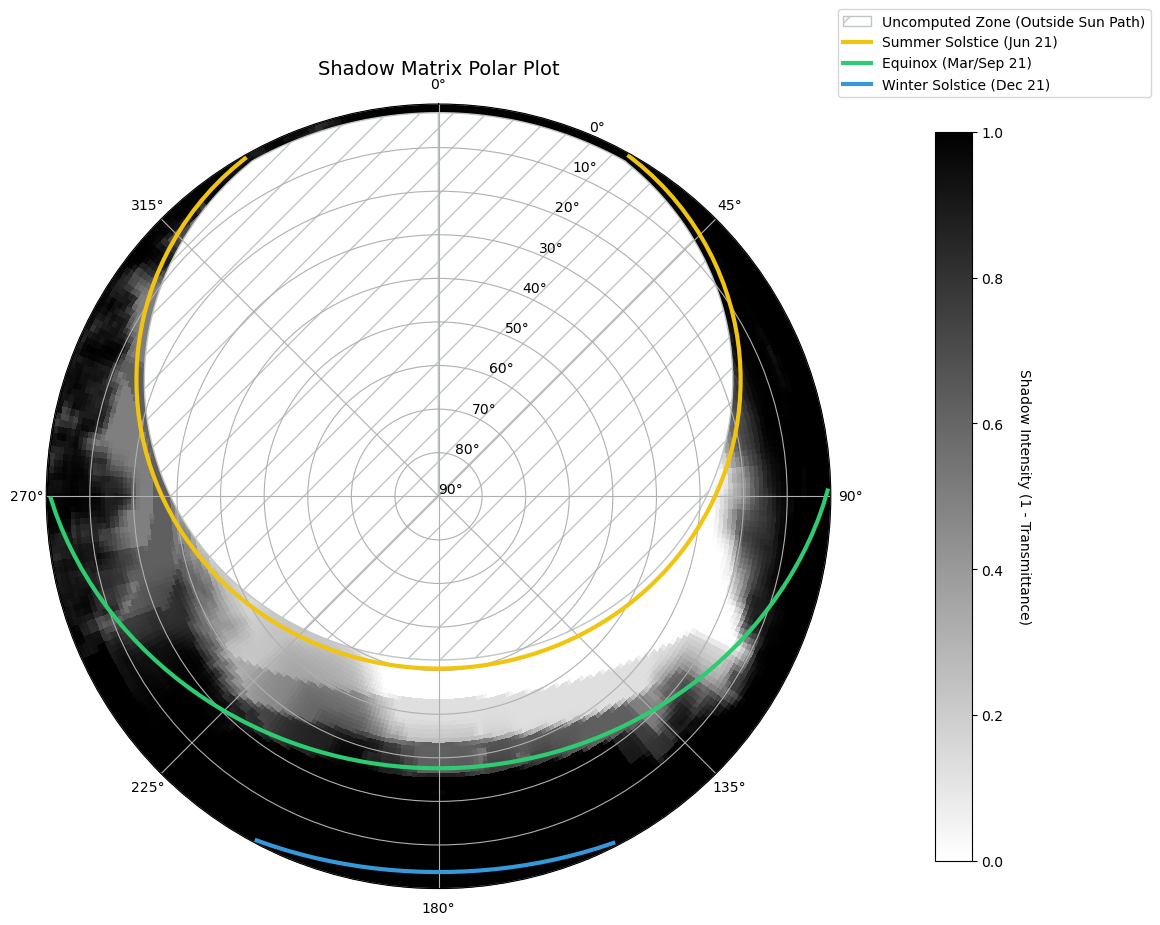

Loading shadow matrix...
Calculating seasonal sun paths...


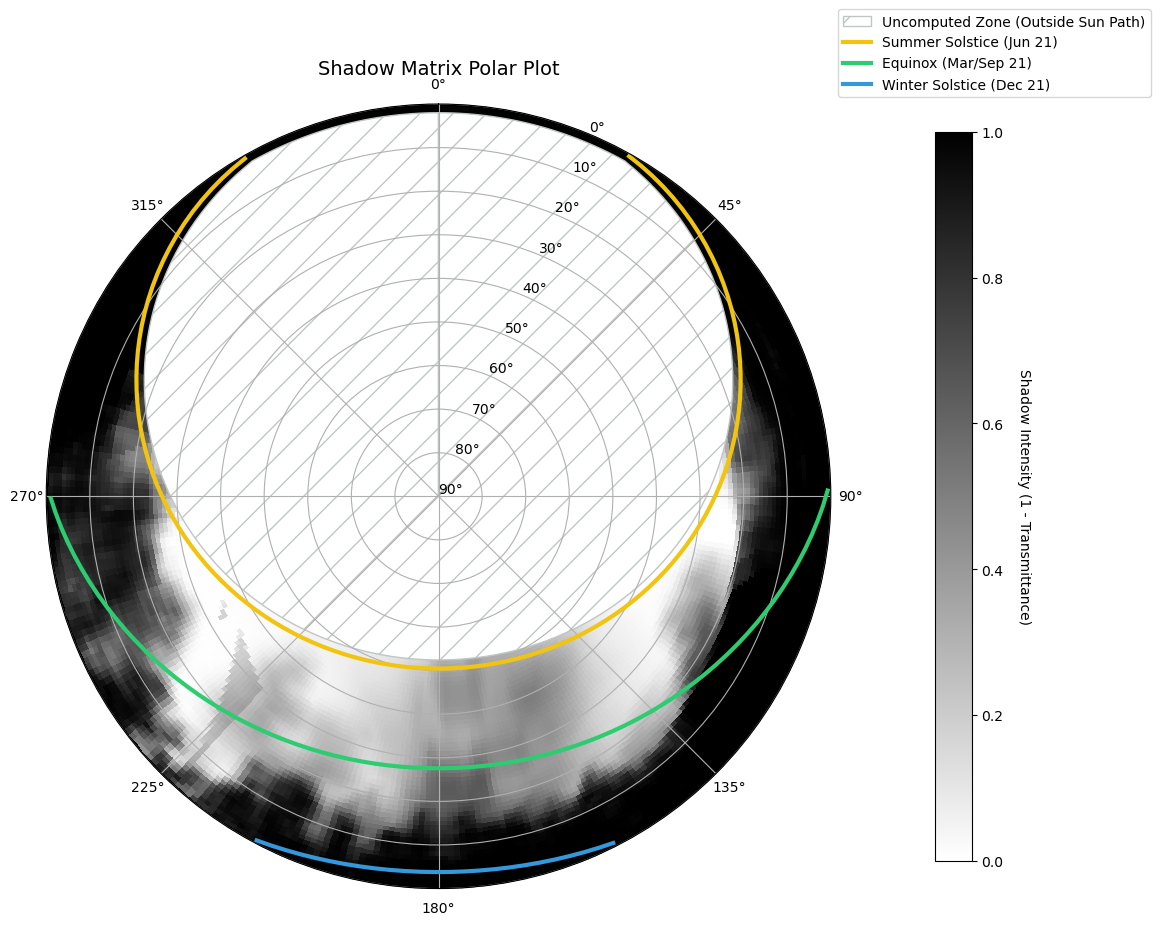

In [143]:
# %% --- 5. Visualise Shadow Matrices ---
if plot_shadow_matrix_with_sunpaths is not None:
    plot_shadow_matrix_with_sunpaths(SHADOW_NORTH)
    plot_shadow_matrix_with_sunpaths(SHADOW_SOUTH)

In [144]:
# %% --- 6. Load Inverter Data (Bank 2 = MPP2) ---
pv_df = load_inverter_data(
    PV_EXCEL,
    expected_interval_min=cfg_combined.interval_minutes,
    energy_column="MPP2",
)
print(f"Loaded {len(pv_df)} inverter records (Bank 2 / MPP2).")

  Energy column: 'Energia MPP2 | Symo 8.2-3-M (1)' (index 3)
Inverter data: 102,263 records, 102235/102262 normal intervals, 27 gaps
  Largest gaps: [965. 925. 905. 875. 825.] min
Loaded 102263 inverter records (Bank 2 / MPP2).


In [145]:
# %% --- 7. Combined PV Analysis for a Single Day ---
def pv_analysis_bank2(
    target_date, shadow_north, shadow_south,
    excel_df, df_extra, plot=True,
):
    """
    Run PV analysis for Bank 2 by analysing North and South sub-arrays
    separately, then summing their outputs.

    Returns
    -------
    day_data : DataFrame with real power (full Bank 2)
    fb_combined : DataFrame with base forecast (no shadows)
    fw_combined : DataFrame with shadow-corrected forecast
    """
    # North sub-array
    day_n, fb_n, fw_n = pv_analysis(
        target_date, shadow_north, excel_df, df_extra,
        cfg=cfg_north, plot=False,
    )
    # South sub-array
    day_s, fb_s, fw_s = pv_analysis(
        target_date, shadow_south, excel_df, df_extra,
        cfg=cfg_south, plot=False,
    )

    # Real power is the full Bank 2 measurement (not split)
    day_data = day_n.copy()  # same inverter data for both

    # Combined forecast = sum of sub-arrays
    fb_combined = fb_n.copy()
    fb_combined["output"] = fb_n["output"] + fb_s["output"]

    fw_combined = fw_n.copy()
    fw_combined["output_shaded"] = fw_n["output_shaded"] + fw_s["output_shaded"]

    if plot:
        import matplotlib.dates as mdates
        fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

        full_idx = day_data.index

        # --- Top: Combined ---
        ax = axes[0]
        ax.plot(full_idx, day_data["Power_W"],
                label="Real Power (Bank 2)", color="#2ecc71", lw=1.5)
        ax.plot(full_idx, fb_combined["output"],
                label="Base Forecast (N+S)", color="#3498db", ls="--")
        ax.plot(full_idx, fw_combined["output_shaded"],
                label="Shadow-Corrected (N+S)", color="#e67e22")
        ax.set_title(f"Bank 2 Combined — {target_date}", fontsize=13)
        ax.set_ylabel("Power (W)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

        # --- Middle: North sub-array ---
        ax = axes[1]
        ax.plot(full_idx, fb_n["output"],
                label="Base (North 6+2)", color="#3498db", ls="--")
        ax.plot(full_idx, fw_n["output_shaded"],
                label="Shaded (North 6+2)", color="#e67e22")
        ax.set_title("North Sub-array (6+2, 8 panels)", fontsize=11)
        ax.set_ylabel("Power (W)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

        # --- Bottom: South sub-array ---
        ax = axes[2]
        ax.plot(full_idx, fb_s["output"],
                label="Base (South 4+2)", color="#3498db", ls="--")
        ax.plot(full_idx, fw_s["output_shaded"],
                label="Shaded (South 4+2)", color="#e67e22")
        ax.set_title("South Sub-array (4+2, 6 panels)", fontsize=11)
        ax.set_ylabel("Power (W)")
        ax.set_xlabel("Time (Local)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

        for a in axes:
            a.xaxis.set_major_locator(mdates.HourLocator(interval=1))
            a.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            a.set_xlim(full_idx[0], full_idx[-1])

        plt.tight_layout()
        plt.show()

    return day_data, fb_combined, fw_combined

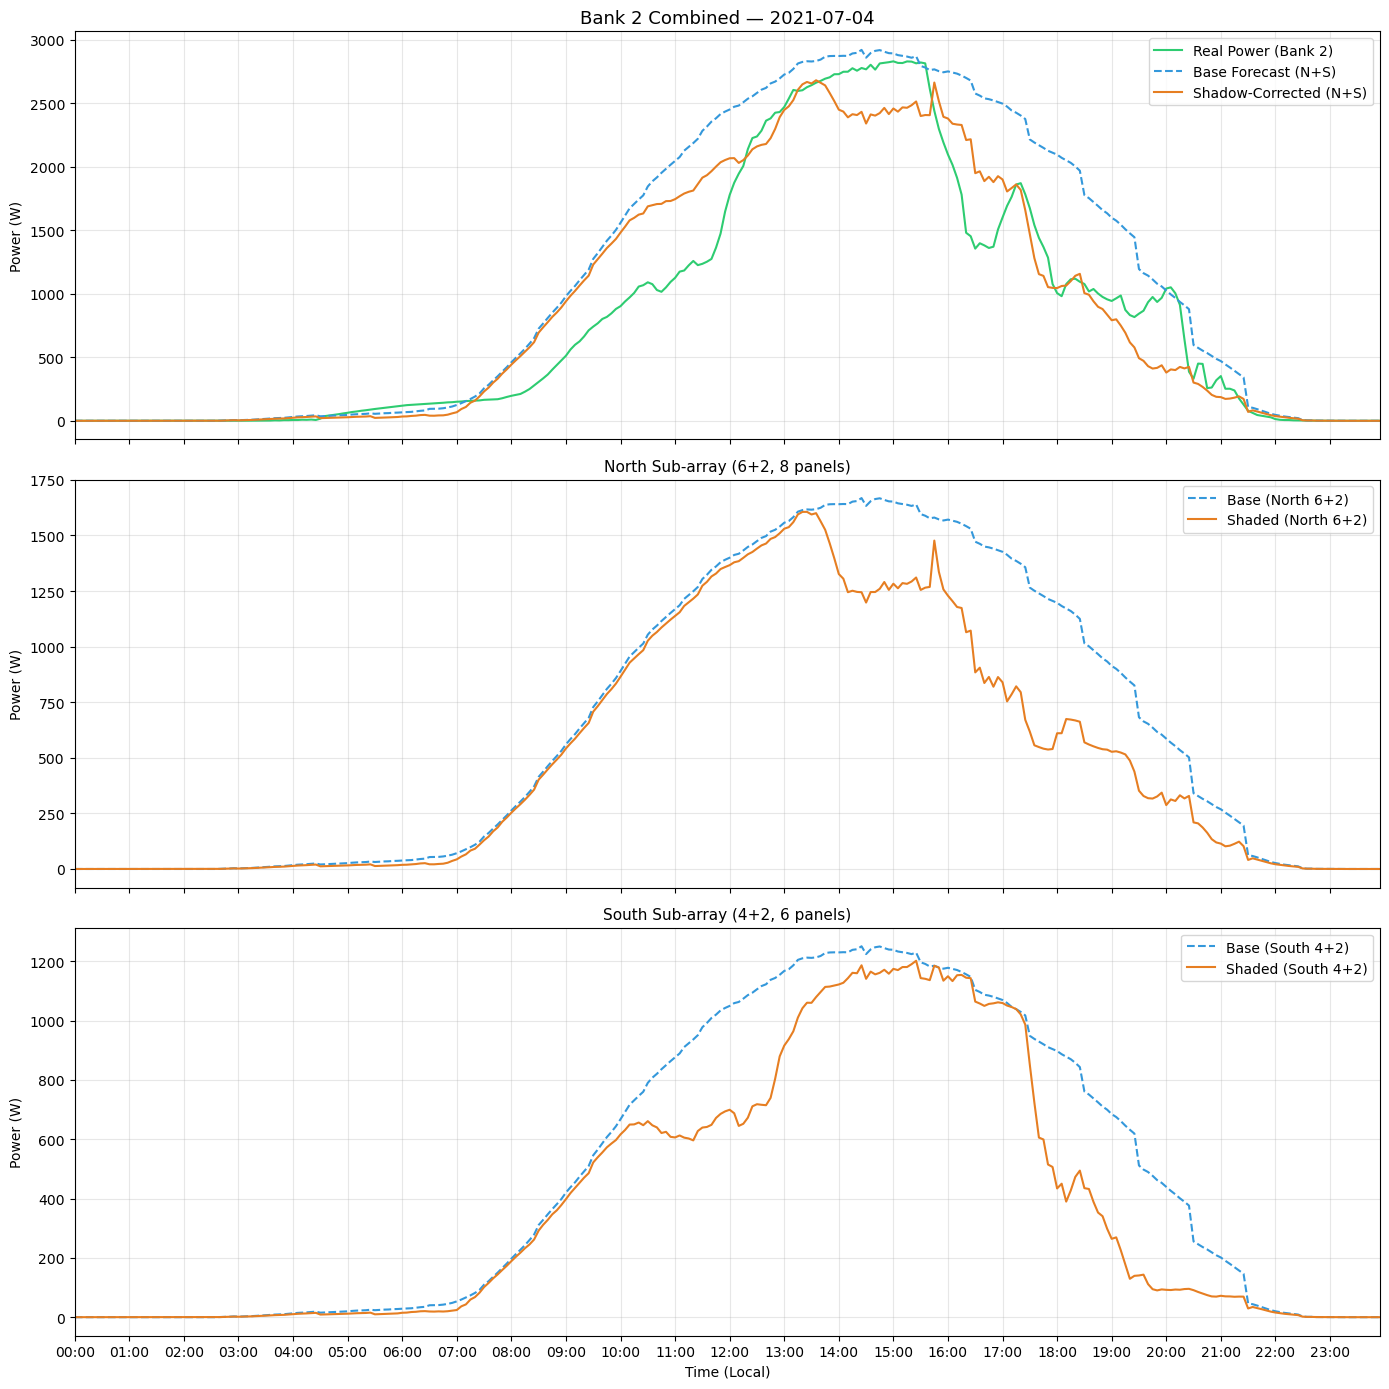

In [146]:
# Single-day test
day_data, forecast_base, forecast_windowed = pv_analysis_bank2(
    second_day, shadow_north, shadow_south,
    pv_df, extra_data_df, plot=True,
)

In [147]:
# %% --- 8. Single-Day Metrics ---
metrics = compute_metrics(
    day_data, forecast_base, forecast_windowed, cfg_combined.interval_minutes
)
print(f"\nMetrics for {second_day} (Bank 2 combined):")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"  {k:15s}: {v:10.2f}")


Metrics for 2021-07-04 (Bank 2 combined):
  RMSE_Base      :     453.67
  RMSE_Shaded    :     288.92
  MAE_Base       :     291.94
  MAE_Shaded     :     191.08
  MBE_Base       :     283.59
  MBE_Shaded     :      47.83
  R2_Base        :       0.71
  R2_Shaded      :       0.88
  Real_Wh        :   19848.17
  Base_Wh        :   26654.33
  Shaded_Wh      :   20996.06


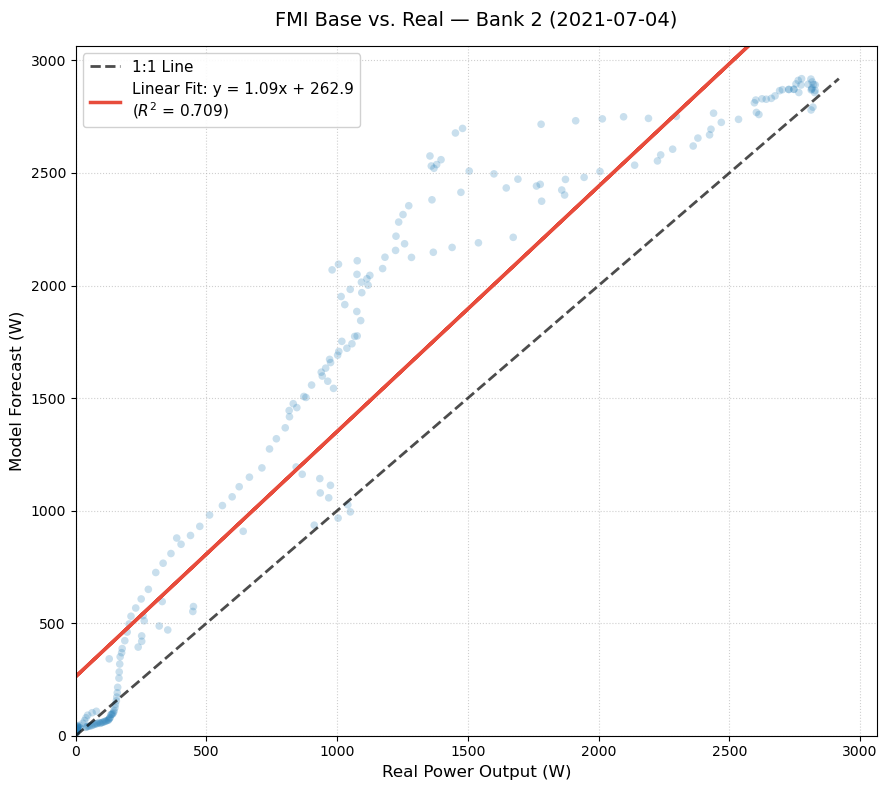

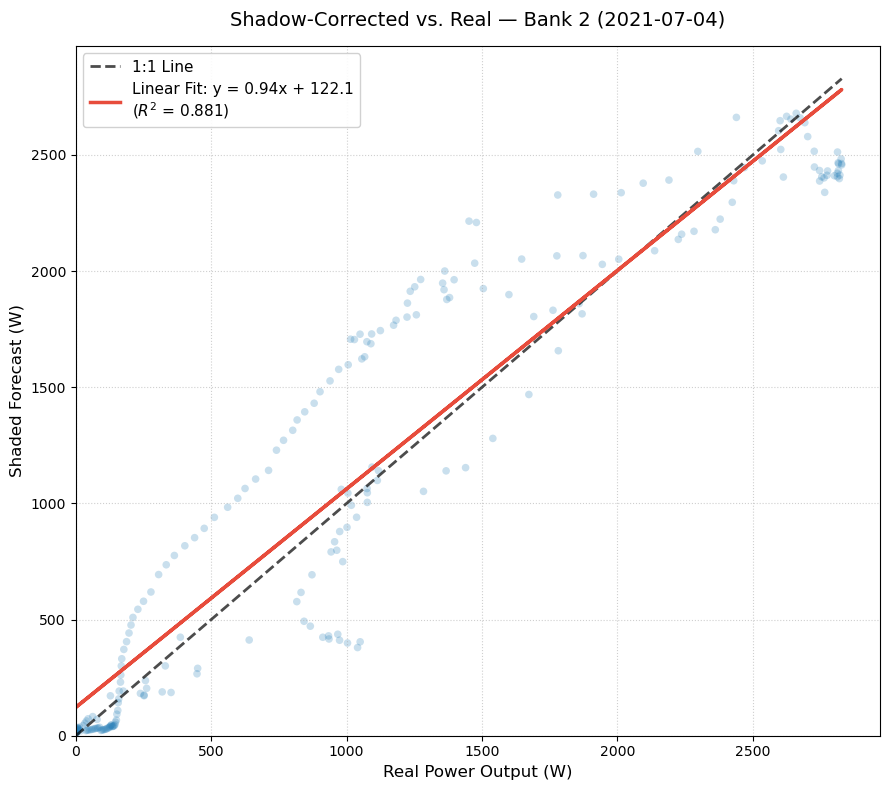

In [148]:
# %% --- 9. Scatter Plots for Single Day ---
plot_real_vs_predicted_scatter(
    day_data["Power_W"].values,
    forecast_base["output"].values,
    title=f"FMI Base vs. Real — Bank 2 ({second_day})",
    ylabel="Model Forecast (W)",
    power_threshold=10.0,
)

plot_real_vs_predicted_scatter(
    day_data["Power_W"].values,
    forecast_windowed["output_shaded"].values,
    title=f"Shadow-Corrected vs. Real — Bank 2 ({second_day})",
    ylabel="Shaded Forecast (W)",
    power_threshold=10.0,
)

Evaluating Bank 2: 100%|██████████| 20/20 [00:01<00:00, 18.15it/s]


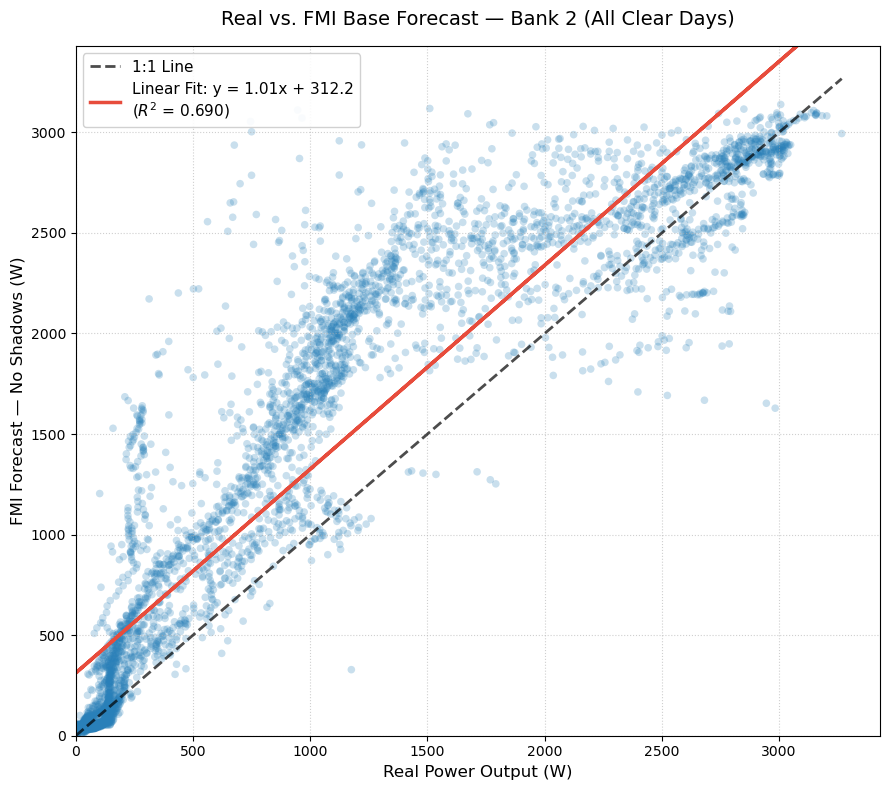

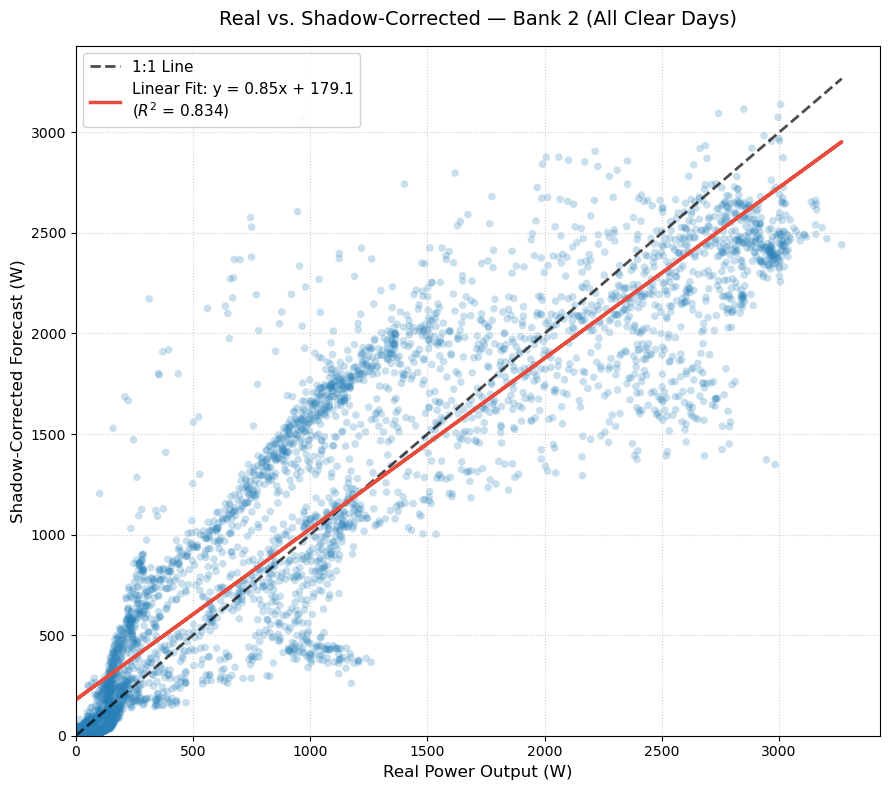


  PV FORECAST PERFORMANCE METRICS (CLEAR DAYS)

  RMSE  Base:     456.83 W
  RMSE  Shaded:   330.27 W  (+27.7%)

  MAE   Base:     275.72 W
  MAE   Shaded:   204.85 W  (+25.7%)

  MBE   Base:    +243.90 W
  MBE   Shaded:   +20.42 W

  R2    Base:      0.677
  R2    Shaded:    0.828

  --- Energy Yield ---
  Real:      356.91 kWh
  Base:      473.99 kWh  (+32.8%)
  Shaded:    366.72 kWh  (+2.7%)


In [149]:
# %% --- 10. Multi-Day Batch Evaluation ---
def _load_cached_extra(date_obj):
    try:
        return load_extra_data_csv(
            f"{EXTRA_DATA_DIR}/extra_data_{date_obj}.csv", cfg=cfg_combined
        )
    except FileNotFoundError:
        print(f"  Warning: No extra data for {date_obj}, skipping.")
        return None


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

daily_stats = []
all_real = []
all_pred_shaded = []
all_pred_base = []

for date_obj in tqdm.tqdm(clear_days["Date"].tolist(), desc="Evaluating Bank 2"):
    df_extra = _load_cached_extra(date_obj)
    if df_extra is None or df_extra.empty:
        continue

    dd, fb, fw = pv_analysis_bank2(
        date_obj, shadow_north, shadow_south,
        pv_df, df_extra, plot=False,
    )
    metrics = compute_metrics(dd, fb, fw, cfg_combined.interval_minutes)

    all_real.extend(dd["Power_W"].fillna(0.0).values)
    all_pred_shaded.extend(fw["output_shaded"].fillna(0.0).values)
    all_pred_base.extend(fb["output"].fillna(0.0).values)

    daily_stats.append({
        "Date": (date_obj.strftime("%Y-%m-%d")
                 if hasattr(date_obj, "strftime") else str(date_obj)),
        **metrics,
    })

results_df = pd.DataFrame(daily_stats)

# Scatter plots
if not results_df.empty:
    plot_real_vs_predicted_scatter(
        all_real, all_pred_base,
        title="Real vs. FMI Base Forecast — Bank 2 (All Clear Days)",
        ylabel="FMI Forecast — No Shadows (W)",
        power_threshold=10.0,
    )
    plot_real_vs_predicted_scatter(
        all_real, all_pred_shaded,
        title="Real vs. Shadow-Corrected — Bank 2 (All Clear Days)",
        ylabel="Shadow-Corrected Forecast (W)",
        power_threshold=10.0,
    )

print_performance_summary(results_df)


In [150]:
# %% --- 10b. Save All Daily Plots ---
import os, matplotlib.dates as mdates

def save_all_day_plots_bank2(output_dir="results/daily_plots_bank2"):
    os.makedirs(output_dir, exist_ok=True)
    saved = 0
    for date_obj in tqdm.tqdm(clear_days["Date"].tolist(), desc="Saving daily plots"):
        df_extra = _load_cached_extra(date_obj)
        if df_extra is None or df_extra.empty:
            continue

        dd, fb, fw = pv_analysis_bank2(
            date_obj, shadow_north, shadow_south,
            pv_df, df_extra, plot=False,
        )
        date_str = (date_obj.strftime("%Y-%m-%d")
                    if hasattr(date_obj, "strftime") else str(date_obj))

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(dd.index, dd["Power_W"],
                label="Real Power (Bank 2)", color="#2ecc71", lw=1.5)
        ax.plot(fb.index, fb["output"],
                label="Base Forecast", color="#3498db", ls="--")
        ax.plot(fw.index, fw["output_shaded"],
                label="Shadow-Corrected", color="#e67e22")
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax.set_xlim(dd.index[0], dd.index[-1])
        ax.set_title(f"Bank 2 (West) — PV Comparison: {date_str}")
        ax.set_xlabel("Time (Local)")
        ax.set_ylabel("Power (W)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, f"bank2_{date_str}.png"),
                    dpi=200, bbox_inches="tight")
        plt.close(fig)
        saved += 1

    print(f"\nSaved {saved} daily plots to {output_dir}/")

save_all_day_plots_bank2()

Saving daily plots: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Saved 20 daily plots to results/daily_plots_bank2/


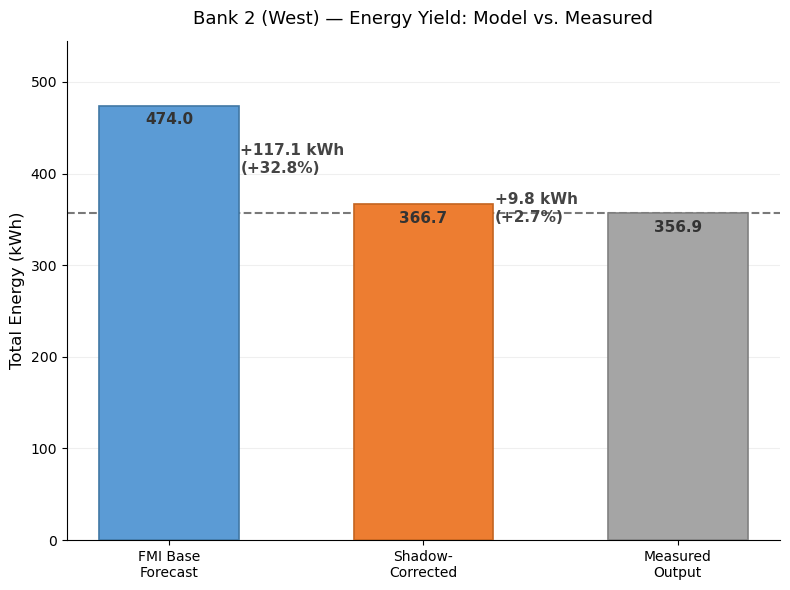

In [151]:
# %% --- 11. Energy Yield Bar Chart ---
def plot_energy_bar_chart(results_df):
    totals = results_df[["Real_Wh", "Base_Wh", "Shaded_Wh"]].sum() / 1000

    labels = ["FMI Base\nForecast", "Shadow-\nCorrected", "Measured\nOutput"]
    values = [totals["Base_Wh"], totals["Shaded_Wh"], totals["Real_Wh"]]
    target = values[2]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ["#5B9BD5", "#ED7D31", "#A5A5A5"]
    edge_colors = ["#4178A4", "#C46420", "#808080"]
    bars = ax.bar(labels, values, color=colors, edgecolor=edge_colors,
                  width=0.55, linewidth=1.2, zorder=3)

    ax.axhline(y=target, color="#404040", ls="--", lw=1.5, alpha=0.7, zorder=2)
    # ax.text(2.35, target, f"{target:,.1f} kWh", va="center", fontsize=9,
    #         color="#404040", fontstyle="italic")

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h - max(values) * 0.015,
                f"{h:,.1f}", ha="center", va="top", fontsize=11,
                fontweight="bold", color="#333333")

    for i in range(2):
        err = values[i] - target
        cx = bars[i].get_x() + bars[i].get_width() / 2
        h = bars[i].get_height()
        sign = "+" if err >= 0 else ""
        err_pct = err / target * 100
        # ax.annotate("", xy=(cx, target), xytext=(cx, h),
        #             arrowprops=dict(arrowstyle="<->", color="#666666", lw=1.5), zorder=4)
        ax.text(cx + 0.28, (h + target) / 2,
                f"{sign}{err:.1f} kWh\n({sign}{err_pct:.1f}%)",
                fontsize=11, color="#444444", ha="left", va="center", fontweight="bold")

    ax.set_ylabel("Total Energy (kWh)", fontsize=12)
    ax.set_title("Bank 2 (West) — Energy Yield: Model vs. Measured", fontsize=13, pad=12)
    ax.set_ylim(0, max(values) * 1.15)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.2, zorder=0)
    plt.tight_layout()
    plt.show()


if not results_df.empty:
    plot_energy_bar_chart(results_df)


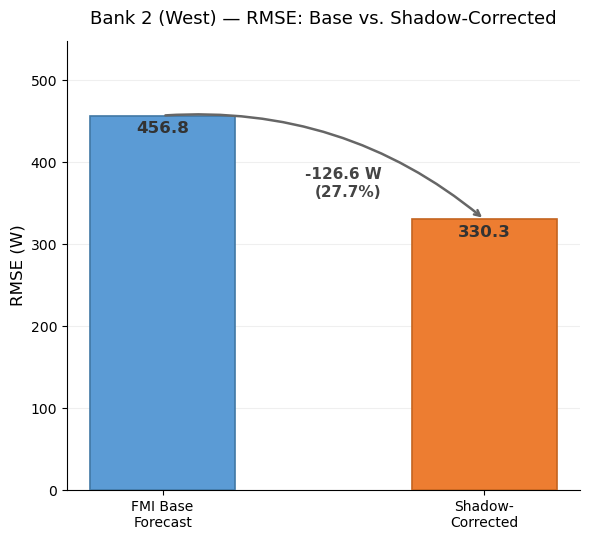

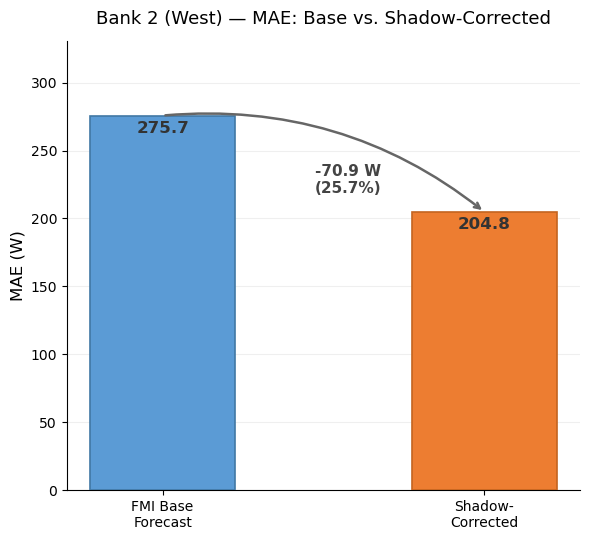

In [152]:
# %% --- 12. RMSE & MAE Bar Charts ---
def _plot_metric_comparison(base_val, shaded_val, metric_name, unit="W"):
    imp = base_val - shaded_val
    imp_pct = (imp / base_val) * 100 if base_val != 0 else 0

    labels = ["FMI Base\nForecast", "Shadow-\nCorrected"]
    values = [base_val, shaded_val]

    fig, ax = plt.subplots(figsize=(6, 5.5))
    colors = ["#5B9BD5", "#ED7D31"]
    edge_colors = ["#4178A4", "#C46420"]
    bars = ax.bar(labels, values, color=colors, edgecolor=edge_colors,
                  width=0.45, linewidth=1.2, zorder=3)

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h - max(values) * 0.015,
                f"{h:,.1f}", ha="center", va="top", fontsize=12,
                fontweight="bold", color="#333333")

    cx0 = bars[0].get_x() + bars[0].get_width() / 2
    cx1 = bars[1].get_x() + bars[1].get_width() / 2
    mid_x = (cx0 + cx1) / 2
    mid_y = (values[0] + values[1]) / 2

    ax.annotate("", xy=(cx1, values[1]), xytext=(cx0, values[0]),
                arrowprops=dict(arrowstyle="->", color="#666666", lw=1.8,
                                connectionstyle="arc3,rad=-0.2"), zorder=4)
    ax.text(mid_x + 0.18, mid_y, f"-{imp:.1f} {unit}\n({imp_pct:.1f}%)",
            fontsize=11, color="#444444", ha="right", va="top", fontweight="bold")

    ax.set_ylabel(f"{metric_name} ({unit})", fontsize=12)
    ax.set_title(f"Bank 2 (West) — {metric_name}: Base vs. Shadow-Corrected",
                 fontsize=13, pad=12)
    ax.set_ylim(0, max(values) * 1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.2, zorder=0)
    plt.tight_layout()
    plt.show()


if not results_df.empty:
    _plot_metric_comparison(
        results_df["RMSE_Base"].mean(),
        results_df["RMSE_Shaded"].mean(),
        "RMSE", "W",
    )
    _plot_metric_comparison(
        results_df["MAE_Base"].mean(),
        results_df["MAE_Shaded"].mean(),
        "MAE", "W",
    )